In [4]:
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import pykitti
import os
from pathlib import Path
from matplotlib import pyplot as plt
from src.vo import VO

In [10]:
def show_features(frame, features):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    
    for i in features:
        x,y = i.pt
        cv2.circle(frame_rgb,(int(x),int(y)),5,255,-1)
    
    return frame_rgb

def show_deltas(vo, max_distance=None):
    frame_rgb = cv2.cvtColor(vo.frames[-1], cv2.COLOR_GRAY2RGB)
    
    for match in vo.matches[-1]:
        if max_distance is not None and match.distance > max_distance:
            continue
        
        p1 = vo.keypoints[-1][match.trainIdx].pt
        p2 = vo.keypoints[-2][match.queryIdx].pt
        cv2.line(frame_rgb, 
                 (int(p1[0]), int(p1[1])), 
                 (int(p2[0]), int(p2[1])),
                 (0,255,0),1)
        
    return frame_rgb

In [6]:
root = Path('sample')
drive = '00'

seq_path = root / 'data_odometry_gray' / 'dataset' / drive / 'image_0'
frames = sorted(os.listdir(seq_path))
vo = VO()

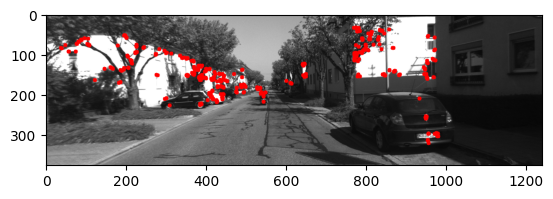

In [7]:
vo.append(cv2.imread(str(seq_path / frames[0]), cv2.IMREAD_UNCHANGED))
vo.append(cv2.imread(str(seq_path / frames[1]), cv2.IMREAD_UNCHANGED))

plt.imshow(show_features(vo.frames[-1], vo.keypoints[-1]))
plt.show()

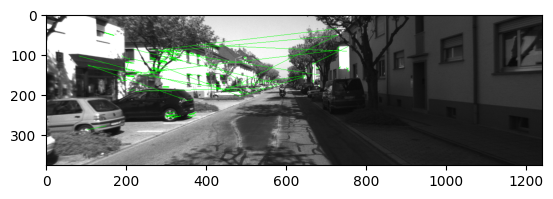

In [11]:
plt.imshow(show_deltas(vo))
plt.show()

In [12]:
vo.reset()
title = "displacement vectors"
cv2.namedWindow(title)

for frame in frames:
    I = cv2.imread(str(seq_path / frame), cv2.IMREAD_UNCHANGED)
    vo.append(I)
    
    if len(vo.frames) >= 2:
        cv2.imshow(title, show_deltas(vo, max_distance=20))
        cv2.waitKey()
        
cv2.destroyWindow(title)

With keypoints detected and matched, we can now focus on deriving matrices that describe the projection characteristics of the camera, as well as solving for a transformation matrix which places the keypoints from $ t $ to $ t_1 $.

For the current frame $F_t$ each keypoint in that frame $k_{i,t}$ represents a specific 3D world space point $p_{i,t}$. If we can match a subset of these points in the next frame $F_{t+1}$, such that $p_{i,t+1}$ represents the same physical point in space as its predecesor, then it follows that some transformation matrix $T_{t,t+1}$ could be applied to $p_{i,t}$ such that it yeilds it's successor. More concretely.

$ p_{i,t+1} = T_{t,t+1} * p_{i,t} $

However, the keypoints themselves $k_i,t$ are projected onto the frame, and thus are two dimensional meaning the projection matrix $P$ must be rank 2. so we can't recover the 3D points directly via an application of the inverse. The transformation from world space points to keypoints is the following.

$ k_{i,t+1} = P * T_{t,t+1} * p_{i,t} $

Our goal is to estimate $T$. There are some known variables such as, $k_{i,t}$, and $P$. However, we're left with as many unknown variables $T_{t,t+1}$, and $p_{i,t}$.

We could write an objective function for $T_{t,t+1}$ to assess the quality of a given solution as:

$ O(T_{t,t+1}) = \frac{1}{n} * \sum_{i=0}^n ||k_{i,t+1} - (P * T_{t,t+1} * p_{i,t})||$

